In [2]:
# import libraries
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
import shap 

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

pd.set_option('display.max_columns', None)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
data = pd.read_csv('/Users/danherman/Desktop/oud_treatment_outcome/data/clean_data/sep6.csv')

In [4]:
data.shape

(23528, 199)

In [5]:
# isolate x and y variables
X = data.drop(columns='outcome')
y = data.outcome

In [6]:
y.value_counts()

outcome
0.0    23139
1.0      389
Name: count, dtype: int64

In [7]:
# split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [8]:
# create xgboost matrix
train = xgb.DMatrix(X_train, label = y_train)
test = xgb.DMatrix(X_test, label = y_test)

In [9]:
feature_columns = list(data.columns)
# remove outcome column
feature_columns.remove('outcome')

In [10]:
parameters = {
                'booster': 'gbtree',
                'colsample_bytree': 1,
                'gamma': 0,
                'learning_rate': 0.3,
                'max_depth': 6,
                'min_child_weight': 1,
                'n_estimators': 200,
                'random_state': 1502,
                'subsample': 1,
                'eval_metric': 'auc',
                'objective': 'binary:logistic',
                }

In [11]:
# run XGBoost 3
model = xgb.train(params=parameters,
                  dtrain=train,
                  num_boost_round=800,
                  evals = [(test, 'yes')],
                  verbose_eval=50)

[14:28:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1693020796942/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	yes-auc:0.99597


[50]	yes-auc:0.99706
[100]	yes-auc:0.99707
[150]	yes-auc:0.99701
[200]	yes-auc:0.99694
[250]	yes-auc:0.99689
[300]	yes-auc:0.99684
[350]	yes-auc:0.99679
[400]	yes-auc:0.99675
[450]	yes-auc:0.99676
[500]	yes-auc:0.99673
[550]	yes-auc:0.99671
[600]	yes-auc:0.99668
[650]	yes-auc:0.99661
[700]	yes-auc:0.99661
[750]	yes-auc:0.99657
[799]	yes-auc:0.99657


In [12]:
# create a radar plot for explainable feature importance
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)


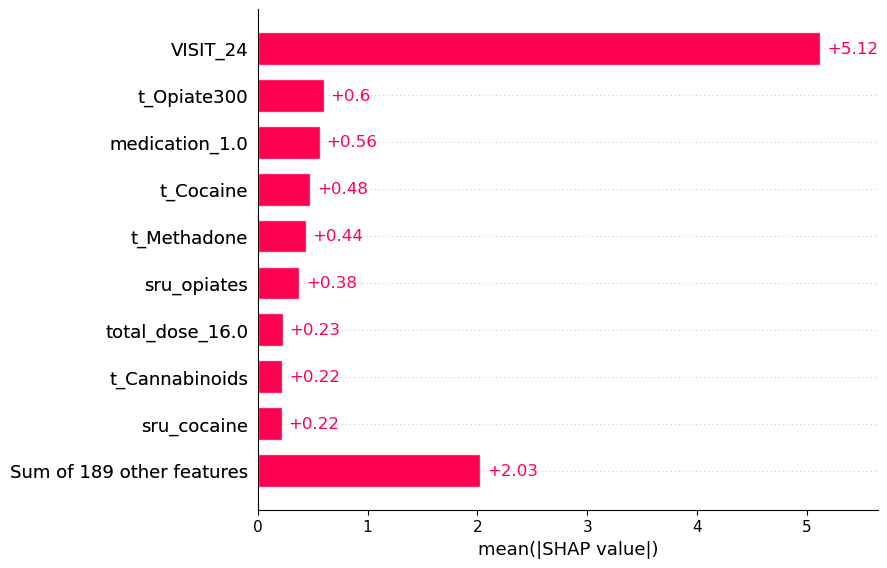

In [15]:
explainer = shap.Explainer(model)
shap_values = explainer(X)

shap.plots.bar(shap_values)

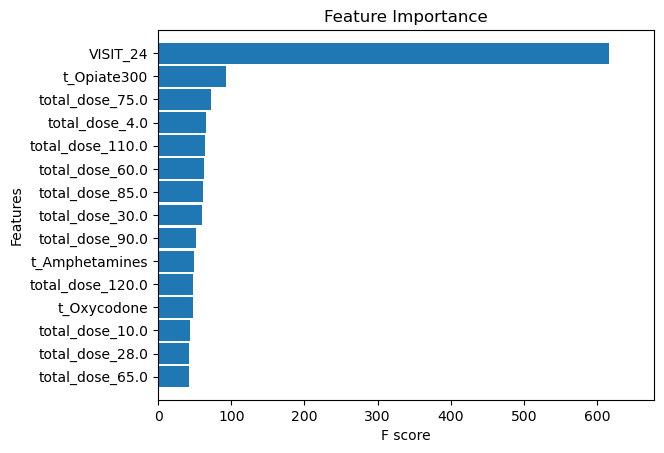

In [16]:
xgb.plot_importance(model, max_num_features=15, height=.9, importance_type='cover', grid=False, show_values=False, title='Feature Importance');

In [17]:
# predictions
predictions = model.predict(test)
predictions = np.where(predictions > 0.05, 1, 0)

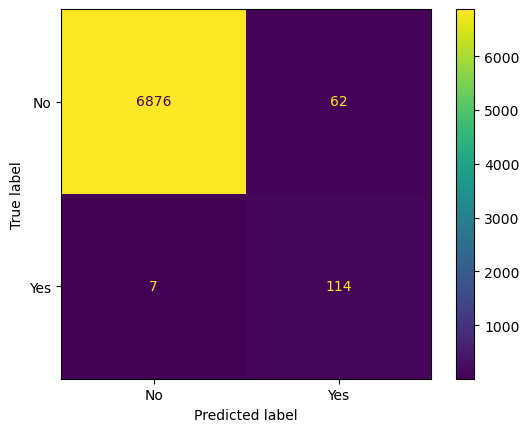

In [18]:
# show confusion matrix display
confusion_matrix = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=['No', 'Yes'])
disp.plot();

In [19]:
report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      6938
         1.0       0.65      0.94      0.77       121

    accuracy                           0.99      7059
   macro avg       0.82      0.97      0.88      7059
weighted avg       0.99      0.99      0.99      7059



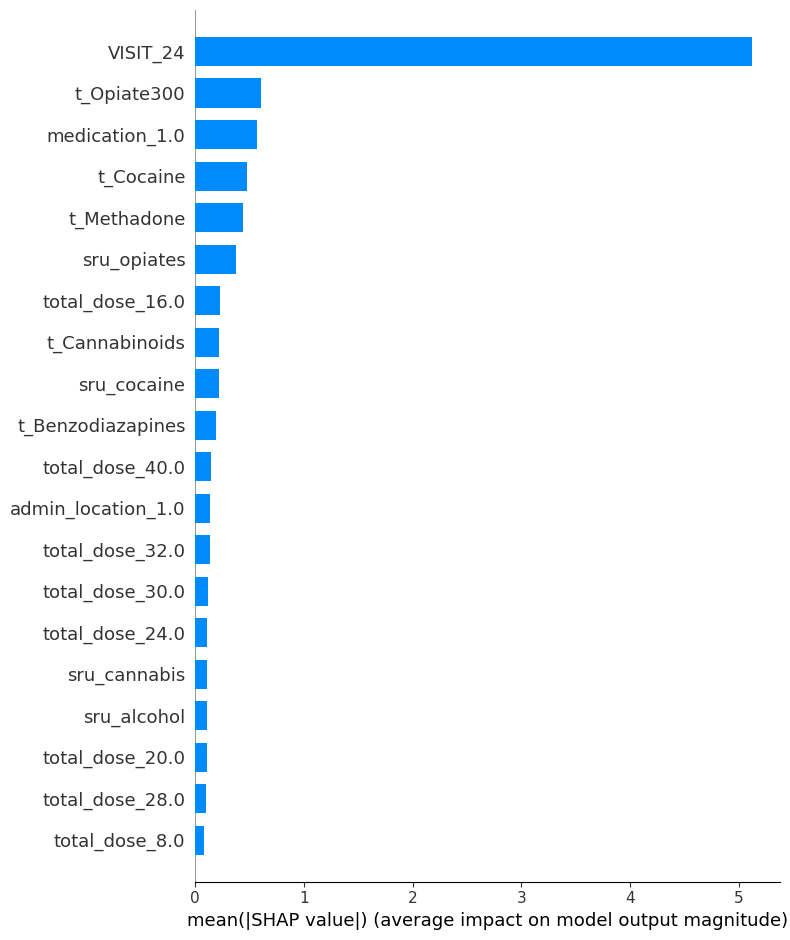

In [20]:
# If we are willing to deal with a bit more complexity, we can use a beeswarm plot to summarize the entire distribution of SHAP values for each feature.

# shap beeswarm plot
shap.summary_plot(shap_values, X_test, plot_type="bar")


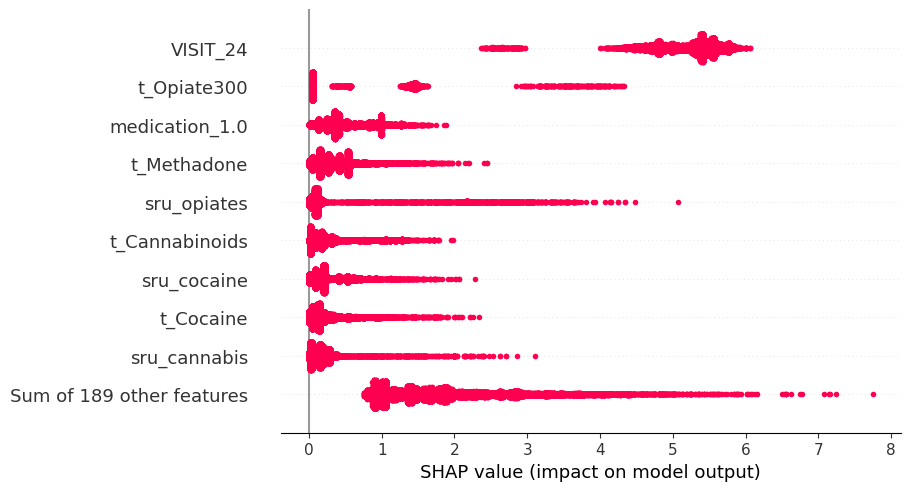

In [22]:
shap.plots.beeswarm(shap_values.abs, color="shap_red")

In [25]:
shap.plots.beeswarm(shap_values, feature_names=feature_columns)

TypeError: beeswarm() got an unexpected keyword argument 'feature_names'

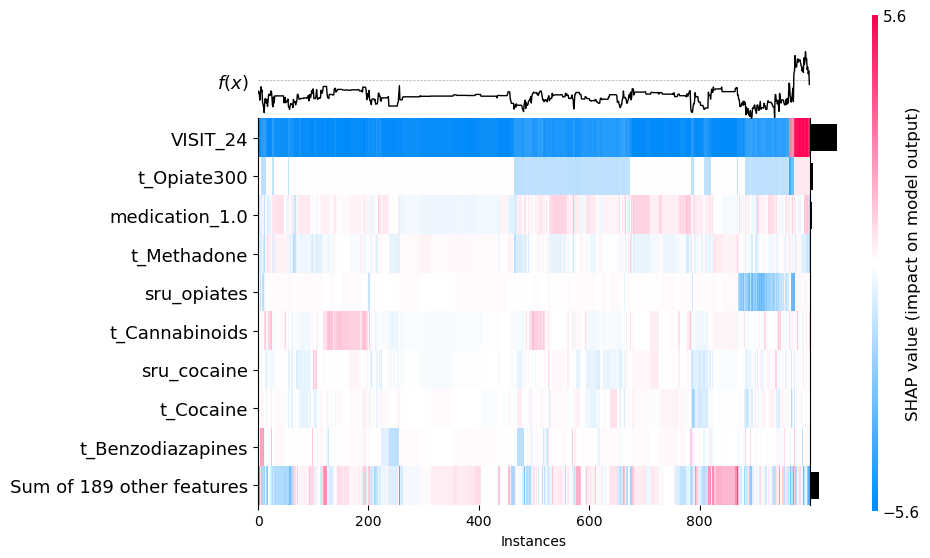

In [26]:
shap.plots.heatmap(shap_values[:1000])

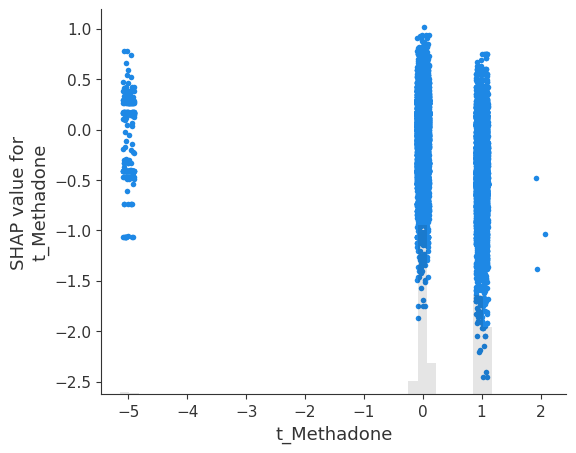

In [27]:
shap.plots.scatter(shap_values[:,"t_Methadone"])

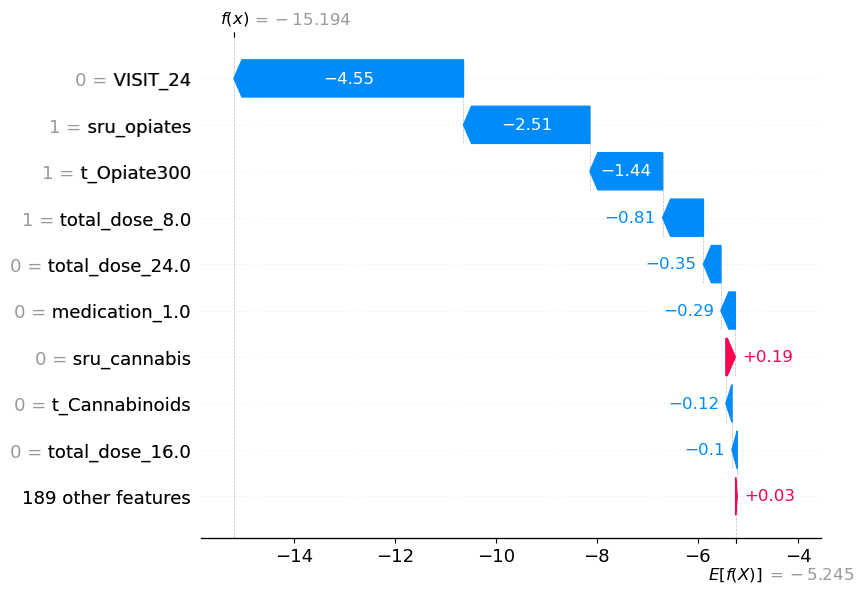

In [28]:
explainer = shap.Explainer(model)
shap_values = explainer(X)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

In [21]:
# save model
model.save_model('xgboost_classifier.model')

# save predictions
predictions = pd.DataFrame(predictions)
predictions.to_csv('xgboost_classifier_predictions.csv')

# save feature importance
feature_importance = pd.DataFrame(model.get_score(importance_type='cover'), index=[0])
feature_importance.to_csv('xgboost_classifier_feature_importance.csv')

# save shap values
shap_values = pd.DataFrame(shap_values)
shap_values.to_csv('xgboost_classifier_shap_values.csv')




ValueError: DataFrame constructor not properly called!